# Working on ExperimentLoader

In [1]:
import sys, json, os
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

PROJECT_DIR = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER"
SRC_DIR = str(Path(PROJECT_DIR) / "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

import multiomic_transformer.utils.experiment_loader as experiment_loader

GROUND_TRUTH_DIR = Path("data/ground_truth_files")

## Load Model

In [54]:
from importlib import reload

reload(experiment_loader)

<module 'multiomic_transformer.utils.experiment_loader' from '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/src/multiomic_transformer/utils/experiment_loader.py'>

In [55]:
exp = experiment_loader.ExperimentLoader(
    experiment_dir = "/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/",
    experiment_name="mESC_E7.5_rep1_hvg_filter_disp_0.6",
    model_num=1,
)

exp.load_trained_model("trained_model.pt")

## Pre-load Ground Truth DataFrames

In [6]:
def load_ground_truth(ground_truth_file):
    if type(ground_truth_file) == str:
        ground_truth_file = Path(ground_truth_file)
        
    if ground_truth_file.suffix == ".csv":
        sep = ","
    elif ground_truth_file.suffix == ".tsv":
        sep="\t"
        
    ground_truth_df = pd.read_csv(ground_truth_file, sep=sep, on_bad_lines="skip", engine="python")
    
    if "chip" in ground_truth_file.name and "atlas" in ground_truth_file.name:
        ground_truth_df = ground_truth_df[["source_id", "target_id"]]

    if ground_truth_df.columns[0] != "Source" or ground_truth_df.columns[1] != "Target":
        ground_truth_df = ground_truth_df.rename(columns={ground_truth_df.columns[0]: "Source", ground_truth_df.columns[1]: "Target"})
    ground_truth_df["Source"] = ground_truth_df["Source"].astype(str).str.upper()
    ground_truth_df["Target"] = ground_truth_df["Target"].astype(str).str.upper()
    
    # Build TF, TG, and edge sets for quick lookup later
    gt = ground_truth_df[["Source", "Target"]].dropna()

    gt_tfs = set(gt["Source"].unique())
    gt_tgs = set(gt["Target"].unique())
    
    gt_pairs = (gt["Source"] + "\t" + gt["Target"]).drop_duplicates()
    
    gt_lookup = (gt_tfs, gt_tgs, set(gt_pairs))
        
    return ground_truth_df, gt_lookup

gt_by_dataset_dict = {
    "Macrophage": {
        "RN204": load_ground_truth(GROUND_TRUTH_DIR / "rn204_macrophage_human_chipseq.tsv"),
        "ChIP-Atlas macrophage": load_ground_truth(GROUND_TRUTH_DIR / "chipatlas_macrophage.csv"),
    },
    "mESC": {
        "ChIP-Atlas mESC": load_ground_truth(GROUND_TRUTH_DIR / "chip_atlas_tf_peak_tg_dist.csv"),
        "RN111": load_ground_truth(GROUND_TRUTH_DIR / "RN111.tsv"),
        "RN112": load_ground_truth(GROUND_TRUTH_DIR / "RN112.tsv"),
        "RN114": load_ground_truth(GROUND_TRUTH_DIR / "RN114.tsv"),
        "RN116": load_ground_truth(GROUND_TRUTH_DIR / "RN116.tsv"),        
    },
    "K562": {
        "ChIP-Atlas K562": load_ground_truth(GROUND_TRUTH_DIR / "chipatlas_K562.csv"),
        "RN117": load_ground_truth(GROUND_TRUTH_DIR / "RN117.tsv"),        
    }
}

## Show Model Settings and Training Parameters

In [7]:
experiment_settings = exp.experiment_settings_df
experiment_settings

,parameter,value
0,EXPERIMENT_NAME,buffer_2_best_settings
1,DATASET_NAME,Macrophage_buffer_2_best_settings
2,ORGANISM_CODE,hg38
3,SAMPLE_NAMES,buffer_2
4,VALIDATION_DATASETS,buffer_4
...,...,...
67,SUBSAMPLE_MAX_WINDOWS_PER_CHROM,NaN
68,SUBSAMPLE_MAX_CELLS,NaN
69,SUBSAMPLE_SEED,42
70,ALLOWED_SAMPLES,NaN


In [8]:
for k, v in exp.model_training_params.items():
    print(f"{k}: {v}")

allowed_samples: None
epochs: 350
batch_size: 16
grad_accum_steps: 1
use_grad_accum: True
use_grad_ckpt: True
d_model: 192
num_heads: 4
num_layers: 3
d_ff: 768
dropout: 0.1
use_shortcut: True
use_dist_bias: True
use_motif_mask: True
motif_mask_threshold: 0.0
motif_prior_scale: 0.0
shortcut_l1: 0.0
shortcut_l2: 0.0
shortcut_dropout: 0.0
shortcut_topk: None
lr: 0.00025
genes: 3585
windows: 8527
tfs: 277
metacells: 147


## Plot the Training Figures

### GPU Usage

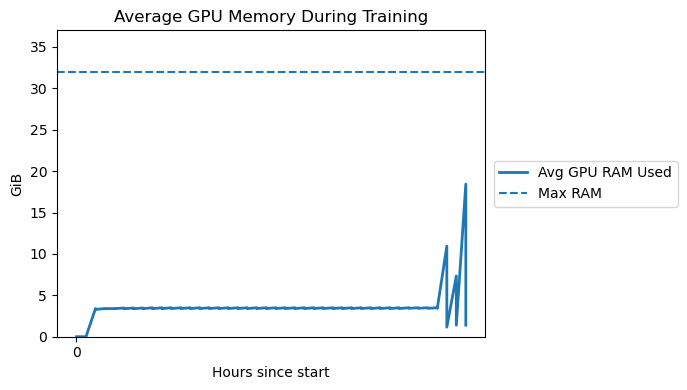

In [9]:
fig = exp.plot_gpu_usage()
fig.show()

### Correlation btw True and Predicted TG Expression

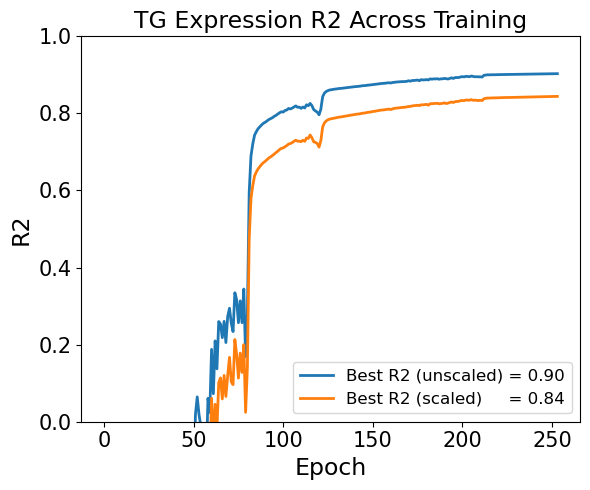

In [10]:
fig = exp.plot_train_correlation()
fig.show()

### AUROC boxplots compared to other methods

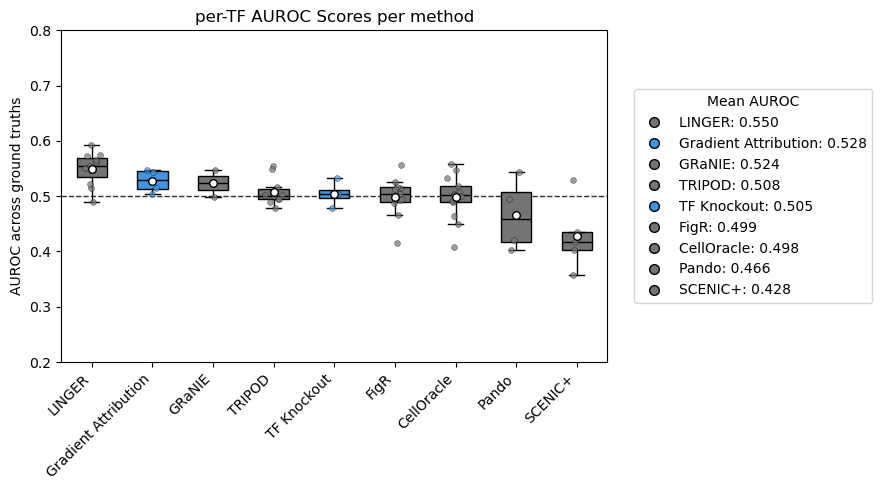

In [11]:
fig = exp.plot_per_tf_auroc_boxplot(agg_by_gt=False, ylim=(0.2, 0.8))
fig.show()

## Load the Inferred GRNs

In [12]:
grad_df = exp.load_grn("Gradient Attribution")
grad_df

,Source,Target,Score
0,ADNP2,5S_RRNA,0.0
1,ADNP2,5_8S_RRNA,0.0
2,ADNP2,7SK,0.0
3,ADNP2,A1BG,0.0
4,ADNP2,A1BG-AS1,0.0
...,...,...,...
11461978,ZSCAN30,ZYG11B,0.0
11461979,ZSCAN30,ZYX,0.0
11461980,ZSCAN30,ZYXP1,0.0
11461981,ZSCAN30,ZZEF1,0.0


In [13]:
tf_ko_df = exp.load_grn("TF Knockout")
tf_ko_df

,Source,Target,Score
0,ADNP2,5S_RRNA,0.0
1,ADNP2,5_8S_RRNA,0.0
2,ADNP2,7SK,0.0
3,ADNP2,A1BG,0.0
4,ADNP2,A1BG-AS1,0.0
...,...,...,...
11461978,ZSCAN30,ZYG11B,0.0
11461979,ZSCAN30,ZYX,0.0
11461980,ZSCAN30,ZYXP1,0.0
11461981,ZSCAN30,ZZEF1,0.0


## Plot the AUROC and AUPRC curves vs a Ground Truth

Experiment: Macrophage_buffer_2_best_settings, Sample type: Macrophage, Ground truth: RN204
            GRN  Ground Truth RN204  Overlap (Score DF in GT)  \
TFs         277                  24                         3   
TGs       41379               26696                     25111   
edges  11461983              169972                     75333   

       Pct of GRN in GT  Pct of GT in GRN  
TFs                1.08             12.50  
TGs               60.69             94.06  
edges              0.66             44.32  


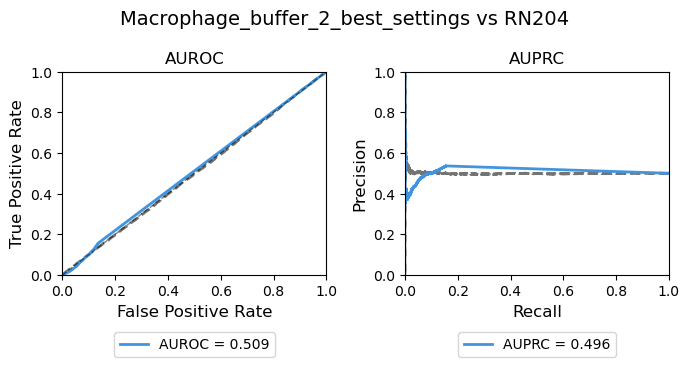

In [14]:

sample_type = exp.experiment_name.split("_")[0]
ground_truth_name = list(gt_by_dataset_dict[sample_type].keys())[0]
print(f"Experiment: {exp.experiment_name}, Sample type: {sample_type}, Ground truth: {ground_truth_name}")

gt_df = gt_by_dataset_dict[sample_type][ground_truth_name]
grad_df = exp.load_grn("Gradient Attribution")

fig, overlap_info_df = exp.plot_auroc_auprc(
    grad_df, 
    gt_df, 
    ground_truth_name=ground_truth_name, 
    return_overlap_info=True,
    balance=True,
    save_fig=True,
    )
fig.show()

print(overlap_info_df)


## Generate performance metrics for multiple experiments

In [16]:
experiments = [
    "Macrophage_buffer_1_hvg_filter_disp_0.01",
    # "Macrophage_buffer_2_hvg_filter_disp_0.01",
    # "Macrophage_buffer_3_hvg_filter_disp_0.01",
    # "Macrophage_buffer_4_hvg_filter_disp_0.01",
    # "Macrophage_buffer_2_hvg_filter_none",
    # "Macrophage_buffer_1_best_settings",
    # "Macrophage_buffer_2_best_settings",
    # "Macrophage_all_bnchmk_best_settings",
    "mESC_E7.5_rep1_hvg_filter_disp_0.01",
    # "mESC_E7.5_rep1_hvg_filter_disp_0.5",
    # "mESC_E7.5_rep2_hvg_filter_disp_0.01",
    "mESC_E7.5_rep2_hvg_filter_disp_0.5",
    # "mESC_E8.5_rep1_hvg_filter_disp_0.01",
    # "mESC_E8.5_rep1_hvg_filter_disp_0.5",
    # "mESC_E8.5_rep2_hvg_filter_disp_0.01",
    # "mESC_E8.5_rep2_hvg_filter_disp_0.5",
    # "mESC_E7.5_rep1_best_settings",
    # "mESC_E7.5_rep2_best_settings",
    # "mESC_E8.5_rep1_best_settings",
    "K562_hvg_filter_disp_0.01",
    # "K562_hvg_filter_disp_0.5",
    # "K562_hvg_filter_none",
    # "K562_sample_1_best_settings"
]

all_gt_results = []
for experiment_name in experiments:
    print(f"Processing experiment: {experiment_name}")
    if "macrophage" in experiment_name.lower():
        gt_dict = gt_by_dataset_dict["Macrophage"]
        sample_type = "Macrophage"
    elif "mesc" in experiment_name.lower():
        gt_dict = gt_by_dataset_dict["mESC"]
        sample_type = "mESC"
    elif "k562" in experiment_name.lower():
        gt_dict = gt_by_dataset_dict["K562"]
        sample_type = "K562"
        
    exp = experiment_loader.ExperimentLoader(
        experiment_dir = "/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/",
        experiment_name=experiment_name,
        model_num=1,
    )

    grad_df = exp.load_grn("Gradient Attribution")
        
    for gt_name, gt_df in gt_dict.items():
        print(f"  - Processing ground truth: {gt_name}")
        fig, overlap_info_df = exp.plot_auroc_auprc(
            grad_df, 
            gt_df, 
            ground_truth_name=gt_name, 
            return_overlap_info=True,
            balance=True,
            no_fig=True,
            )
        results_dict = {
            "sample_type": sample_type,
            "experiment": experiment_name,
            "ground_truth": gt_name,
            "num_tf_in_gt": overlap_info_df.loc["TFs", "Overlap (Score DF in GT)"],
            "pct_tf_overlap": overlap_info_df.loc["TFs", "Pct of GRN in GT"],
            "pct_tg_overlap": overlap_info_df.loc["TGs", "Pct of GRN in GT"],
            "pct_edges_in_gt": overlap_info_df.loc["edges", "Pct of GRN in GT"],
        }

        results_df = pd.DataFrame(results_dict, index=[0])
        
        merged_results = pd.merge(results_df, exp.auroc_auprc_scores, on=["experiment", "ground_truth"], how="left")
        
        all_gt_results.append(merged_results)

full_results_df = pd.concat(all_gt_results, axis=0)
full_results_df


Processing experiment: Macrophage_buffer_1_hvg_filter_disp_0.01
  - Processing ground truth: RN204
  - Processing ground truth: ChIP-Atlas macrophage
Processing experiment: mESC_E7.5_rep1_hvg_filter_disp_0.01
  - Processing ground truth: ChIP-Atlas mESC
  - Processing ground truth: RN111
  - Processing ground truth: RN112
  - Processing ground truth: RN114
  - Processing ground truth: RN116
Processing experiment: mESC_E7.5_rep2_hvg_filter_disp_0.5
  - Processing ground truth: ChIP-Atlas mESC
  - Processing ground truth: RN111
  - Processing ground truth: RN112
  - Processing ground truth: RN114
  - Processing ground truth: RN116
Processing experiment: K562_hvg_filter_disp_0.01
  - Processing ground truth: ChIP-Atlas K562
  - Processing ground truth: RN117


,sample_type,experiment,ground_truth,num_tf_in_gt,pct_tf_overlap,pct_tg_overlap,pct_edges_in_gt,auroc,auprc
0,Macrophage,Macrophage_buffer_1_hvg_filter_disp_0.01,RN204,9,2.72,60.69,1.65,0.509691,0.526979
0,Macrophage,Macrophage_buffer_1_hvg_filter_disp_0.01,ChIP-Atlas macrophage,9,2.72,91.46,2.49,0.514560,0.516770
0,mESC,mESC_E7.5_rep1_hvg_filter_disp_0.01,ChIP-Atlas mESC,48,10.02,91.58,9.18,0.552209,0.554548
0,mESC,mESC_E7.5_rep1_hvg_filter_disp_0.01,RN111,36,7.52,70.43,5.29,0.531404,0.544347
0,mESC,mESC_E7.5_rep1_hvg_filter_disp_0.01,RN112,25,5.22,48.03,2.51,0.555683,0.548411
0,mESC,mESC_E7.5_rep1_hvg_filter_disp_0.01,RN114,17,3.55,55.11,1.96,0.519743,0.522810
0,mESC,mESC_E7.5_rep1_hvg_filter_disp_0.01,RN116,12,2.51,16.05,0.40,0.557586,0.577472
0,mESC,mESC_E7.5_rep2_hvg_filter_disp_0.5,ChIP-Atlas mESC,37,16.09,91.58,14.73,0.522168,0.514049
0,mESC,mESC_E7.5_rep2_hvg_filter_disp_0.5,RN111,23,10.00,70.43,7.04,0.509172,0.516705
0,mESC,mESC_E7.5_rep2_hvg_filter_disp_0.5,RN112,14,6.09,48.03,2.92,0.537191,0.523367


In [17]:
def plot_auroc_improvement_boxplot(
    full_results_df, 
    column="auroc", 
    title="AUROC Variance across Ground Truths",
    hbar_y=0,
    ylim=(-0.3, 0.3)
    ):
    # ---- group data by ground_truth ----
    groups = full_results_df.groupby("ground_truth")[column]
    labels = groups.groups.keys()
    data = [groups.get_group(g).values for g in labels]

    color_dict = {
        "ChIP-Atlas mESC": "#da8b47",
        "ChIP-Atlas macrophage": "#e67d5f",
        "ChIP-Atlas K562": "#dab45d",
        "RN111": "#71c071",
        "RN112": "#ba4444",
        "RN114": "#cbb4e1",
        "RN116": "#91645b",
        "RN117": "#d8aacb",
        "RN204": "#9ec5e1",
    }

    means = [np.mean(groups.get_group(g)) for g in labels]

    plt.figure(figsize=(10, 6))
    # ---- boxplot ----
    bp = plt.boxplot(
        data,
        patch_artist=True,
        showfliers=False,
        zorder=1,
    )

    plt.axhline(hbar_y, color="#747474", linestyle="--")


    # ---- color boxes ----
    for label, box in zip(labels, bp["boxes"]):
        box.set_facecolor(color_dict.get(label, "#4195df"))
    for median in bp["medians"]:
        median.set_color("black")

    # ---- scatter points ----
    for i, g in enumerate(labels, start=1):
        yvals = groups.get_group(g).values
        xvals = np.random.normal(i, 0.05, size=len(yvals))  # jitter per box
        
        plt.scatter(
            xvals,
            yvals,
            color=color_dict.get(g, "#4195df"),
            alpha=0.7,
            s=40,
            edgecolor="k",
            zorder=2
        )

    # ---- plot mean per ground_truth ----

    plt.scatter(
        range(1, len(means) + 1),
        means,
        color="white",
        s=60,
        edgecolor="k",
        zorder=3,
    )

    # ---- formatting ----
    plt.xticks(range(1, len(labels) + 1), labels, rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel(f"{column}\n(per experiment)", fontsize=14)
    plt.title(f"{title}", fontsize=14)

    # ---- plot mean per ground_truth + build legend ----
    legend_handles = []

    for i, (g, m) in enumerate(zip(labels, means), start=1):
        h = plt.scatter(
            i,
            m,
            color="white",
            s=70,
            edgecolor="k",
            zorder=3,
            label=f"{g} mean = {m:.3f}"
        )
        legend_handles.append(h)


    plt.legend(
        handles=legend_handles,
        bbox_to_anchor=(1.02, 0.75),
        loc="upper left",
        frameon=False,
        fontsize=12,
        title="Mean AUROC",
        title_fontsize=14,
    )

    plt.ylim(ylim)
    plt.tight_layout()
    plt.show()


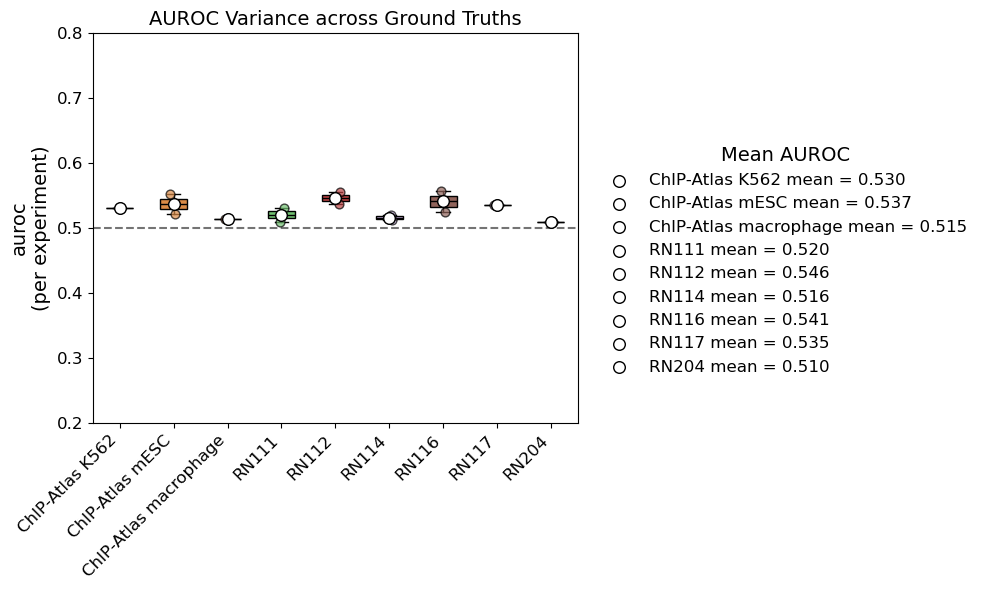

In [18]:
plot_auroc_improvement_boxplot(
    full_results_df, 
    ylim=(0.2, 0.8),
    hbar_y=0.5
    )


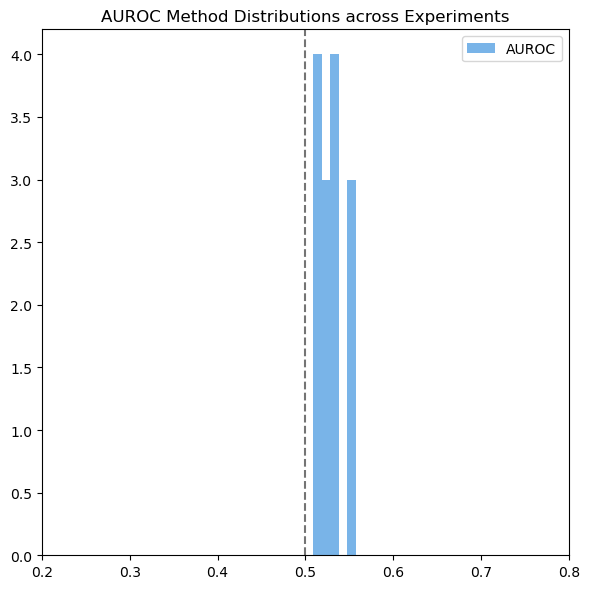

In [19]:
fig = plt.figure(figsize=(6, 6))

plt.hist(full_results_df["auroc"], bins=5, color="#4195df", alpha=0.7, label="AUROC")
plt.axvline(0.5, color="#747474", linestyle="--")
plt.legend()
plt.xlim(0.2, 0.8)
plt.title("AUROC Method Distributions across Experiments")
plt.tight_layout()
plt.show()


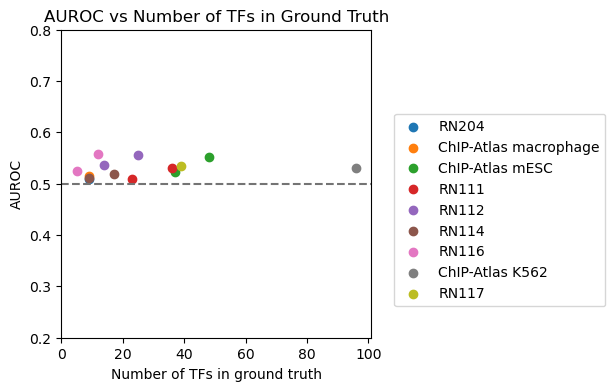

In [20]:
# Scatterplot of auroc vs percent of tf overlap in gt
plt.figure(figsize=(4,4))
# df = full_results_df[full_results_df["sample_type"] == "K562"]
df = full_results_df
for gt_name in df["ground_truth"].unique():
    subset = df[df["ground_truth"] == gt_name]
    plt.scatter(subset["num_tf_in_gt"], subset["auroc"], label=gt_name)
plt.title("AUROC vs Number of TFs in Ground Truth")
plt.xlabel("Number of TFs in ground truth")
plt.ylabel("AUROC")
plt.hlines(0.5, xmin=0, xmax=df["num_tf_in_gt"].max() +5, color="#747474", linestyle="--")
plt.legend(
    bbox_to_anchor=(1.05, 0.75), loc='upper left'
)

plt.ylim(0.2, 0.8)
plt.xlim(0, df["num_tf_in_gt"].max() + 5)

plt.show()

### Load the AUROC and AUPRC comparison results

In [21]:
exp.load_eval_results()
results_df = exp.results_df[exp.results_df["method"] == "Gradient Attribution"]
results_df

,method,gt,auroc,auprc,pos_rate,lift_auprc,precision@0.10%,lift@0.10%,precision@0.50%,lift@0.50%,precision@1.00%,lift@1.00%,precision@5.00%,lift@5.00%
14,Gradient Attribution,ChIP-Atlas,0.530222,0.522556,0.5,1.045112,0.793307,1.586614,0.747606,1.495212,0.715813,1.431626,0.663536,1.327072
15,Gradient Attribution,RN117,0.535325,0.525976,0.5,1.051951,0.977011,1.954023,0.816280,1.632559,0.705792,1.411585,0.636642,1.273284


## Compare Predicted vs True TG Expression

You can test the model's ability to predict TG expression using `run_forward_pass`, which runs the model predictions for the held-out test dataset. This returns three dataframes, one with the predicted TG expression, one with the true TG expression, and one that compares the per-gene mean and standard deviation of the predicted and true expression.

In [56]:
tg_expr_pred_df, tg_expr_true_df, pred_true_comparison_df = exp.run_forward_pass(num_batches=10)

Running forward pass: 100%|█████████████████████| 10/10 [00:05<00:00,  1.83it/s]


In [57]:
tg_expr_pred_df

,E7.5_REP1.GGGCATTGTGAAGCCT,E7.5_REP1.TGAAGCAAGTTATCTC,E7.5_REP1.TAGTGTGGTCCTAGTT,E7.5_REP1.CAGGACCTCTAGCGTG,E7.5_REP1.CCGATGCAGCTCAAAC,E7.5_REP1.ACAGGTAAGGCTGGCT,E7.5_REP1.AGGTACGCAGCATGTC,E7.5_REP1.CGGACAACAAGGTCGA,E7.5_REP1.CTATGTTTCGAAGTGA,E7.5_REP1.AATCCTAAGGACCAGG,...,E7.5_REP1.CCTACTGGTTTGCTGT,E7.5_REP1.TATCCGGAGCACTAAC,E7.5_REP1.TCGTTACGTCGCGCAA,E7.5_REP1.GCATTAGGTTAGTACG,E7.5_REP1.CGTTGCAAGCGAGCGA,E7.5_REP1.TACAGCTAGCTTCCCG,E7.5_REP1.ACTTGTAAGTTAGGCT,E7.5_REP1.ACCAGGGAGGAGCAAC,mean_expr,std_expr
1700034P13RIK,0.248536,0.194882,0.401311,0.362949,0.186195,0.228717,0.322298,0.358958,0.240103,0.305966,...,0.235399,0.262733,0.238011,0.177614,0.157412,0.243613,0.257622,0.170101,0.248881,0.062023
4933439K11RIK,0.058995,0.012181,0.073879,0.064206,0.093903,0.015990,0.092454,0.091047,0.084056,0.088779,...,0.026485,0.066840,0.038681,0.087896,0.026159,0.019476,0.019129,0.005522,0.059956,0.031179
A830018L16RIK,0.204982,0.131254,0.265168,0.134749,0.134902,0.078543,0.227991,0.172285,0.308803,0.327793,...,0.171083,0.479135,0.200979,0.186525,0.190024,0.180026,0.117921,0.105808,0.219224,0.082495
ACKR3,0.076203,0.052959,0.019358,0.060715,0.049223,0.031722,0.047309,0.079982,0.045174,0.041970,...,0.059900,0.058461,0.088294,0.092294,0.007059,0.076868,0.065637,0.083965,0.056673,0.028229
ADAM23,0.172590,0.167548,0.412202,0.308133,0.220931,0.198963,0.274084,0.302987,0.296407,0.306860,...,0.227115,0.376457,0.157011,0.243261,0.263480,0.193975,0.185382,0.236779,0.240292,0.059164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TSGA10,0.046319,0.072588,0.048271,0.038604,0.061444,0.051922,0.048401,0.046506,0.042991,0.039521,...,0.050989,0.048780,0.034214,0.051816,0.040063,0.078153,0.071471,0.052390,0.053040,0.019578
WNT6,-0.005273,0.192644,0.020789,-0.002852,0.047563,0.213799,0.063198,0.043498,0.044433,0.076351,...,0.157337,0.028736,0.061351,0.026779,0.031094,0.203321,0.149476,0.009725,0.062821,0.058396
XKR4,0.413053,0.372439,0.951058,0.707596,0.553170,0.417721,0.724789,0.580544,0.805579,0.692968,...,0.530626,0.940677,0.426748,0.418556,0.411652,0.480697,0.490115,0.273629,0.537457,0.185520
XPR1,0.270651,0.299059,0.437323,0.392474,0.319145,0.315101,0.350606,0.471033,0.350064,0.368228,...,0.469741,0.374451,0.364961,0.338745,0.838005,0.400279,0.396498,0.154319,0.415381,0.176251


In [58]:
tg_expr_true_df

,E7.5_REP1.GGGCATTGTGAAGCCT,E7.5_REP1.TGAAGCAAGTTATCTC,E7.5_REP1.TAGTGTGGTCCTAGTT,E7.5_REP1.CAGGACCTCTAGCGTG,E7.5_REP1.CCGATGCAGCTCAAAC,E7.5_REP1.ACAGGTAAGGCTGGCT,E7.5_REP1.AGGTACGCAGCATGTC,E7.5_REP1.CGGACAACAAGGTCGA,E7.5_REP1.CTATGTTTCGAAGTGA,E7.5_REP1.AATCCTAAGGACCAGG,...,E7.5_REP1.CCTACTGGTTTGCTGT,E7.5_REP1.TATCCGGAGCACTAAC,E7.5_REP1.TCGTTACGTCGCGCAA,E7.5_REP1.GCATTAGGTTAGTACG,E7.5_REP1.CGTTGCAAGCGAGCGA,E7.5_REP1.TACAGCTAGCTTCCCG,E7.5_REP1.ACTTGTAAGTTAGGCT,E7.5_REP1.ACCAGGGAGGAGCAAC,mean_expr,std_expr
1700034P13RIK,0.226129,0.217746,0.243371,0.242042,0.223723,0.217609,0.232503,0.248120,0.229137,0.236043,...,0.225596,0.230251,0.237649,0.228262,0.227165,0.229064,0.223981,0.217739,0.229265,0.007096
4933439K11RIK,0.061865,0.061797,0.063117,0.063484,0.063482,0.060743,0.065487,0.064783,0.064488,0.064517,...,0.061422,0.062575,0.062144,0.063551,0.060574,0.060994,0.062000,0.060626,0.062850,0.001425
A830018L16RIK,0.178597,0.190195,0.296291,0.235996,0.184717,0.181181,0.285189,0.175902,0.296989,0.300448,...,0.179373,0.352525,0.173684,0.177252,0.174329,0.177122,0.175773,0.199060,0.214993,0.046409
ACKR3,0.053601,0.049166,0.049750,0.049585,0.049257,0.049103,0.052238,0.057507,0.051030,0.048707,...,0.048448,0.051024,0.057748,0.058270,0.049092,0.049234,0.048986,0.049323,0.051429,0.003510
ADAM23,0.123841,0.115780,0.182354,0.155069,0.144221,0.115760,0.147910,0.125998,0.149117,0.134293,...,0.116321,0.176955,0.118982,0.126302,0.117347,0.116213,0.116189,0.122491,0.133387,0.019298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TSGA10,0.047826,0.048603,0.047128,0.047919,0.048000,0.047029,0.048734,0.047699,0.047197,0.046798,...,0.047572,0.047164,0.047052,0.048723,0.047962,0.048361,0.047131,0.048639,0.047780,0.000895
WNT6,0.112490,0.170503,0.113807,0.109848,0.119853,0.172631,0.116232,0.113044,0.109291,0.142474,...,0.163805,0.109609,0.114936,0.119299,0.111587,0.158354,0.169788,0.109398,0.122815,0.019482
XKR4,0.387535,0.406876,0.655436,0.553686,0.463165,0.442603,0.664958,0.427894,0.781727,0.651449,...,0.526942,0.812488,0.407075,0.430512,0.364082,0.450013,0.446112,0.380900,0.495164,0.130765
XPR1,0.534073,0.606463,0.597323,0.569363,0.555388,0.596414,0.550117,0.552769,0.552878,0.593411,...,0.611557,0.572248,0.547062,0.550061,0.810197,0.581046,0.576806,0.537271,0.604644,0.082219


In [59]:
pred_true_comparison_df

,mean_expr_pred,std_expr_pred,mean_expr_true,std_expr_true,diff
1700034P13RIK,0.248881,0.062023,0.229265,0.007096,0.019616
4933439K11RIK,0.059956,0.031179,0.062850,0.001425,-0.002894
A830018L16RIK,0.219224,0.082495,0.214993,0.046409,0.004231
ACKR3,0.056673,0.028229,0.051429,0.003510,0.005244
ADAM23,0.240292,0.059164,0.133387,0.019298,0.106905
...,...,...,...,...,...
TSGA10,0.053040,0.019578,0.047780,0.000895,0.005261
WNT6,0.062821,0.058396,0.122815,0.019482,-0.059994
XKR4,0.537457,0.185520,0.495164,0.130765,0.042293
XPR1,0.415381,0.176251,0.604644,0.082219,-0.189263


### Plot the True vs Predicted TG Expression Values

You can also compare how well the model predicts the TG expression using `plot_true_vs_predicted_tg_expression`, which creates a scatterplot of each gene's predicted mean expression vs its true mean expression.

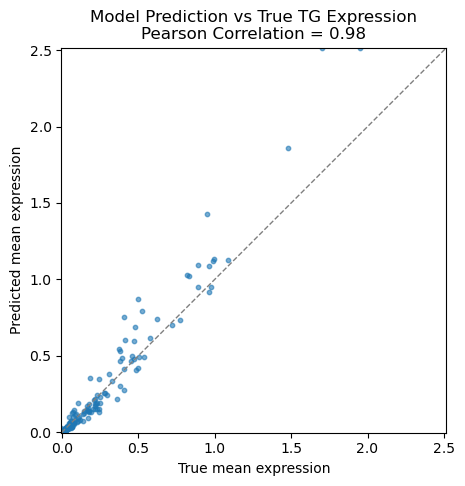

In [60]:
fig = exp.plot_true_vs_predicted_tg_expression(num_batches=25, rerun_forward_pass=False)
fig.show()

### Plot Prediction Accuracy vs Gene Expression Variance

We can also see that the model tends to struggle more to accurately predict the mean expression for genes with a high variance by plotting the per-gene prediction accuracy by the standard deviation of the gene's expression.

In [65]:
pred_true_comparison_df

,mean_expr_pred,std_expr_pred,mean_expr_true,std_expr_true,diff
1700034P13RIK,0.248881,0.062023,0.229265,0.007096,0.019616
4933439K11RIK,0.059956,0.031179,0.062850,0.001425,-0.002894
A830018L16RIK,0.219224,0.082495,0.214993,0.046409,0.004231
ACKR3,0.056673,0.028229,0.051429,0.003510,0.005244
ADAM23,0.240292,0.059164,0.133387,0.019298,0.106905
...,...,...,...,...,...
TSGA10,0.053040,0.019578,0.047780,0.000895,0.005261
WNT6,0.062821,0.058396,0.122815,0.019482,-0.059994
XKR4,0.537457,0.185520,0.495164,0.130765,0.042293
XPR1,0.415381,0.176251,0.604644,0.082219,-0.189263


Spearman: rho = -0.180, p-value = 0.015


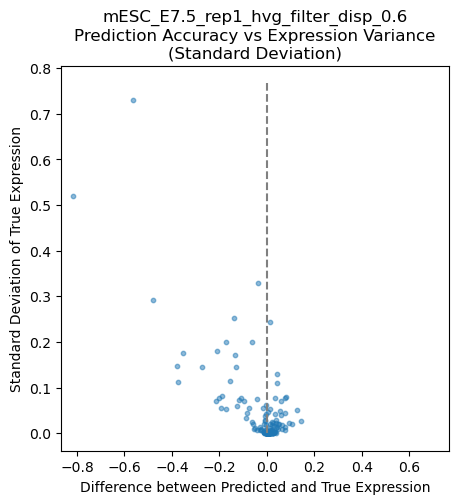

In [96]:
from scipy.stats import spearmanr

fig = plt.figure(figsize=(5,5))

plt.scatter(pred_true_comparison_df["diff"], pred_true_comparison_df["std_expr_true"], alpha=0.5, s=10)

lims = [
    np.min([plt.xlim()[0], plt.ylim()[0]]),  # min of both axes
    np.max([plt.xlim()[1], plt.ylim()[1]]),  # max of both axes
]
plt.vlines(x=0, ymin=0, ymax=lims[1], colors='grey', linestyles='dashed', label="Perfect Prediction")
plt.xlim(lims)
plt.title(f"{exp.experiment_name}\nPrediction Accuracy vs Expression Variance\n(Standard Deviation)")
plt.xlabel("Difference between Predicted and True Expression")
plt.ylabel("Standard Deviation of True Expression")

spearman_corr = spearmanr(pred_true_comparison_df["diff"], pred_true_comparison_df["std_expr_true"])

print(f"Spearman: rho = {spearman_corr[0]:.3f}, p-value = {spearman_corr[1]:.3f}")

plt.show()